<a href="https://colab.research.google.com/github/wwy99/Unsupervised-Classification/blob/master/Car_Make.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Car Model Predictor - Amin Sheikh, Weiyu Wang, and James Bonsu.

In [189]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from PIL import Image
import numpy as np
import concurrent.futures
from tqdm import tqdm


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


import torchvision.transforms as transforms
from torchvision.models import resnet18

from torchvision.models.resnet import ResNet18_Weights
import torch.nn as nn
import torch.optim as optim


import os
import datetime
from torch.utils.tensorboard import SummaryWriter



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

dataset_path = '/content/drive/My Drive/CSE 5095/Dataset'

In [ ]:
image_folder = os.path.join(dataset_path, 'part_0')
image_files = os.listdir(image_folder)

In [ ]:
# Create a new dataframe for training the model
train_df = pd.DataFrame()

# Assigning the make, make + model, and make + model + year labels
train_df['label1'] = image_files['make']
train_df['label2'] = image_files['make'] + '_' + image_files['model']
train_df['label3'] = image_files['make'] + '_' + image_files['model'] + '_' + image_files['year']

# Displaying the new dataframe
print(train_df)


             label1                 label2                      label3
0           Porsche          Porsche_Macan          Porsche_Macan_2017
1              Audi                Audi_A5                Audi_A5_2011
2        Alfa Romeo      Alfa Romeo_Giulia      Alfa Romeo_Giulia_2020
3     Mercedes-Benz  Mercedes-Benz_E Class  Mercedes-Benz_E Class_2017
4            Nissan        Nissan_Frontier        Nissan_Frontier_2019
...             ...                    ...                         ...
8163       Cadillac           Cadillac_ATS           Cadillac_ATS_2016
8164            Ram               Ram_2500               Ram_2500_2012
8165      Chevrolet        Chevrolet_Spark        Chevrolet_Spark_2017
8166            GMC      GMC_Sierra 2500HD      GMC_Sierra 2500HD_2012
8167          smart           smart_fortwo           smart_fortwo_2011

[8168 rows x 3 columns]


In [ ]:
import cv2  # For reading images

# Function to read image data
def read_image(file_path):
    img = cv2.imread(file_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    return img

# Assuming 'image_folder' is the folder path where images are stored
image_files['file_path'] = image_files['filename'].apply(lambda x: os.path.join(image_folder, x))

# Load image data
train_df['image_data'] = image_files['file_path'].apply(read_image)

# Displaying the new dataframe with image data
print(train_df[['label1', 'label2', 'label3', 'image_data']])


             label1                 label2                      label3  \
0           Porsche          Porsche_Macan          Porsche_Macan_2017   
1              Audi                Audi_A5                Audi_A5_2011   
2        Alfa Romeo      Alfa Romeo_Giulia      Alfa Romeo_Giulia_2020   
3     Mercedes-Benz  Mercedes-Benz_E Class  Mercedes-Benz_E Class_2017   
4            Nissan        Nissan_Frontier        Nissan_Frontier_2019   
...             ...                    ...                         ...   
8163       Cadillac           Cadillac_ATS           Cadillac_ATS_2016   
8164            Ram               Ram_2500               Ram_2500_2012   
8165      Chevrolet        Chevrolet_Spark        Chevrolet_Spark_2017   
8166            GMC      GMC_Sierra 2500HD      GMC_Sierra 2500HD_2012   
8167          smart           smart_fortwo           smart_fortwo_2011   

                                             image_data  
0     [[[255, 255, 255], [255, 255, 255], [255, 255,.

In [4]:


## WEIYU


dataset_path = '/content/drive/MyDrive/SCAN-CAR/Dataset'

image_files = []
for i in range(3):
  image_folder = os.path.join(dataset_path, 'part_{}'.format(i))
  for file in os.listdir(image_folder):
    image_files.append(os.path.join(image_folder, file))

image_files_df = pd.DataFrame(image_files, columns=['file_path'])


In [5]:

image_files_df.head()


,file_path
0,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...
1,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...
2,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...
3,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...
4,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...


In [6]:

def extract_info(file_path):
  parts = file_path.split('/')
  filename = parts[-1]
  info = filename.split('_')
  make = info[0]
  model = info[1]
  year = info[2]
  return make, model, year

image_files_df['make'] = image_files_df['file_path'].apply(lambda x: extract_info(x)[0])
image_files_df['model'] = image_files_df['file_path'].apply(lambda x: extract_info(x)[1])
image_files_df['year'] = image_files_df['file_path'].apply(lambda x: extract_info(x)[2])

image_files_df.head()


,file_path,make,model,year
0,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...,Toyota,Corolla,2019
1,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...,Hyundai,Palisade,2020
2,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...,Chevrolet,Malibu,2015
3,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...,FIAT,124 Spider,2017
4,/content/drive/MyDrive/SCAN-CAR/Dataset/part_0...,Lincoln,MKZ,2016


In [7]:
# Create a new dataframe for training the model
train_df = pd.DataFrame()

# Assigning the make, make + model, and make + model + year labels
train_df['label1'] = image_files_df['make']
train_df['label2'] = image_files_df['make'] + '_' + image_files_df['model']
train_df['label3'] = image_files_df['make'] + '_' + image_files_df['model'] + '_' + image_files_df['year']

train_df.head()

,label1,label2,label3
0,Toyota,Toyota_Corolla,Toyota_Corolla_2019
1,Hyundai,Hyundai_Palisade,Hyundai_Palisade_2020
2,Chevrolet,Chevrolet_Malibu,Chevrolet_Malibu_2015
3,FIAT,FIAT_124 Spider,FIAT_124 Spider_2017
4,Lincoln,Lincoln_MKZ,Lincoln_MKZ_2016


In [7]:
len(train_df)

24284

In [8]:
import cv2
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def read_image_opencv(file_path):
    try:
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def process_batch(batch):
    return [read_image_opencv(file_path) for file_path in batch]

def load_images_in_batches(file_paths, batch_size=100):
    # Create batches of file_paths
    batches = [file_paths[i:i + batch_size] for i in range(0, len(file_paths), batch_size)]
    images = []
    with ThreadPoolExecutor(max_workers=16) as executor:
        # Processing batches concurrently
        all_results = list(tqdm(executor.map(process_batch, batches), total=len(batches), desc="Loading Images"))
    # Flatten the list of results
    for batch_result in all_results:
        images.extend(batch_result)
    # Remove None values if any image failed to load
    return [img for img in images if img is not None]

# List of image paths from the DataFrame
image_paths = image_files_df['file_path'].tolist()

# Loading images in batches concurrently and storing them in the DataFrame
train_df['image_data'] = load_images_in_batches(image_paths)







Loading Images: 100%|██████████| 243/243 [09:39<00:00,  2.38s/it]


In [9]:
# prompt: check how many none in image data

train_df['image_data'].isnull().sum()


0

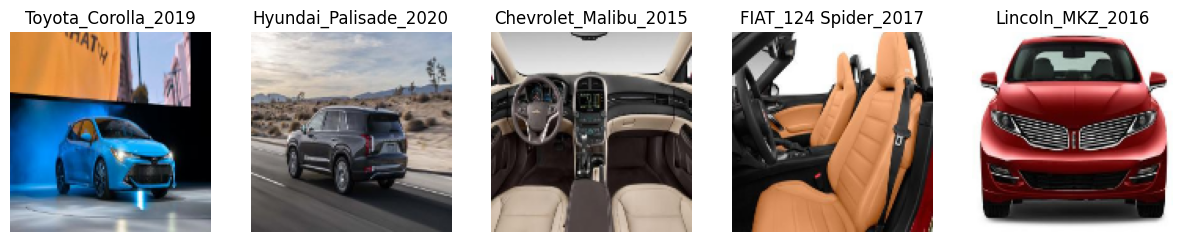

In [10]:


fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i, ax in enumerate(axes):
  ax.imshow(train_df['image_data'][i])
  ax.set_title(train_df['label3'][i])
  ax.axis('off')
plt.show()


In [11]:


print("Number of classes in label1:", len(train_df['label1'].unique()))
print("Number of classes in label2:", len(train_df['label2'].unique()))
print("Number of classes in label3:", len(train_df['label3'].unique()))


Number of classes in label1: 42
Number of classes in label2: 318
Number of classes in label3: 2004


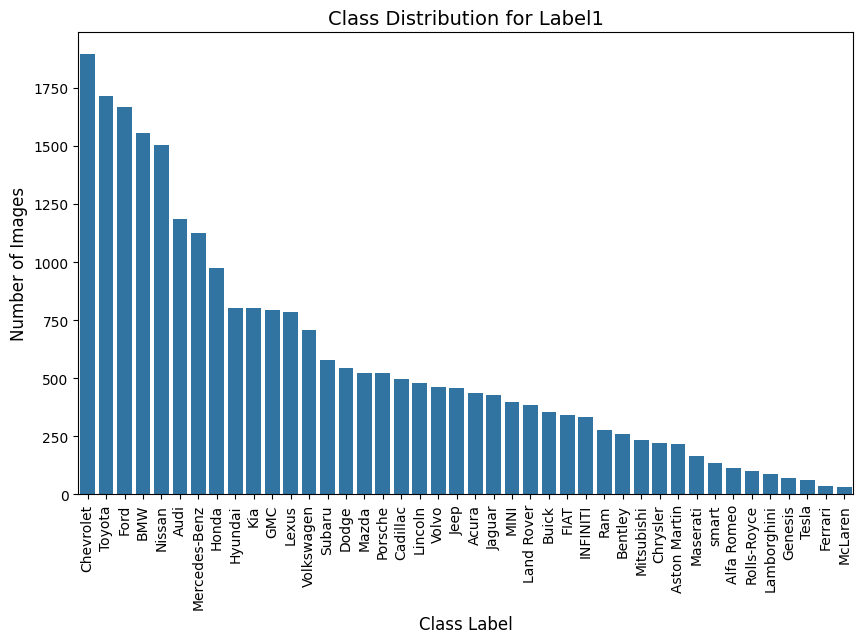

In [12]:
import seaborn as sns

# Get the number of images for each class in label1
class_counts = train_df['label1'].value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution for Label1', fontsize=14)
plt.xticks(rotation=90)
plt.show()


In [13]:


print(train_df.shape)


(24284, 4)


In [14]:
train_df.head()

,label1,label2,label3,image_data
0,Toyota,Toyota_Corolla,Toyota_Corolla_2019,"[[[214, 136, 54], [213, 135, 53], [212, 134, 5..."
1,Hyundai,Hyundai_Palisade,Hyundai_Palisade_2020,"[[[246, 242, 239], [243, 239, 236], [244, 240,..."
2,Chevrolet,Chevrolet_Malibu,Chevrolet_Malibu_2015,"[[[203, 190, 174], [209, 196, 181], [212, 200,..."
3,FIAT,FIAT_124 Spider,FIAT_124 Spider_2017,"[[[192, 192, 192], [191, 191, 191], [187, 187,..."
4,Lincoln,Lincoln_MKZ,Lincoln_MKZ_2016,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [15]:


train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24284 entries, 0 to 24283
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label1      24284 non-null  object
 1   label2      24284 non-null  object
 2   label3      24284 non-null  object
 3   image_data  24284 non-null  object
dtypes: object(4)
memory usage: 759.0+ KB


In [190]:
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class SimCLRDataset(Dataset):
    def __init__(self, image_data, transform=None):
        self.image_data = image_data
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image = Image.fromarray(self.image_data[idx].astype('uint8'), 'RGB')
        xi = self.transform(image) if self.transform else transforms.ToTensor()(image)
        xj = self.transform(image) if self.transform else transforms.ToTensor()(image)
        return xi, xj  # Returning a tuple of transformed images





In [191]:
def get_simclr_transformations():
    return transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


In [192]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

import torch
import torch.nn as nn
import torchvision.models as models

class ResNetSimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {
            "resnet18": models.resnet18(pretrained=False, num_classes=out_dim),
            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim)
        }

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # Adding MLP projection head
        self.backbone.fc = nn.Sequential(
            nn.Linear(dim_mlp, dim_mlp),
            nn.ReLU(),
            nn.Linear(dim_mlp, out_dim)
        )

    def _get_basemodel(self, model_name):
        if model_name not in self.resnet_dict:
            raise ValueError("Invalid backbone architecture. Choose either 'resnet18' or 'resnet50'")
        return self.resnet_dict[model_name]

    def forward(self, x):
        return self.backbone(x)




In [193]:
import torch
import torch.nn.functional as F

def info_nce_loss(features, temperature=0.5):
    """
    Computes the InfoNCE loss from the feature representations.
    """
    batch_size = features.shape[0] // 2
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(features.device)

    features = F.normalize(features, dim=1)

    similarity_matrix = torch.matmul(features, features.T)

    # Ensure the mask is created with the correct size
    mask = torch.eye(similarity_matrix.size(0), dtype=torch.bool).to(features.device)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

    # Select the positives and negatives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

    # Prepare logits and labels for CrossEntropy loss
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(features.device)

    logits = logits / temperature
    return F.cross_entropy(logits, labels)


In [194]:
# Hyperparameters
epochs = 10  # Total number of epochs to train
learning_rate = 3e-4  # Learning rate for the optimizer
temperature = 0.07  # Temperature used in softmax for contrastive learning
batch_size = 32  # Batch size for training

In [195]:
transform = get_simclr_transformations()
dataset = SimCLRDataset(train_df['image_data'], transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)


In [196]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSimCLR(base_model='resnet50', out_dim=128).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [197]:


optimizer = optim.Adam(model.parameters(), lr= learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [198]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

In [201]:
# Initialize the best loss to a high value
best_loss = float('inf')

def train_one_epoch(model, data_loader, optimizer, temperature, epoch_index, writer):
    model.train()
    total_loss = 0.0
    for batch_index, ((xi, xj)) in enumerate(data_loader):
        images = torch.cat([xi, xj], dim=0).to(device)
        optimizer.zero_grad()

        features = model(images)
        loss = info_nce_loss(features, temperature=temperature)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log loss every 10 batches
        if (batch_index + 1) % 10 == 0:
            writer.add_scalar('Loss/train', loss.item(), epoch_index * len(data_loader) + batch_index)

    avg_loss = total_loss / len(data_loader)
    writer.add_scalar('Loss/average_train', avg_loss, epoch_index)
    return avg_loss

# Setup TensorBoard writer
log_dir = "/content/drive/MyDrive/SCAN-CAR/train_log"
writer = SummaryWriter(log_dir)









In [202]:
for epoch in range(epochs):
    avg_loss = train_one_epoch(model, train_loader, optimizer, temperature, epoch, writer)
    scheduler.step()  # Adjust the learning rate based on the scheduler
    print(f'Epoch {epoch + 1}, Average Loss: {avg_loss}')

    # Save the model if it has the best loss so far
    if avg_loss < best_loss:
        best_loss = avg_loss
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, filename=os.path.join(log_dir, f'/content/drive/MyDrive/SCAN-CAR/best_model.pth.tar'))
        print(f"New best model saved with loss {best_loss}")

writer.close()

Epoch 1, Average Loss: 2.0616325213032747
New best model saved with loss 2.0616325213032747
Epoch 2, Average Loss: 1.0829125117407485
New best model saved with loss 1.0829125117407485
Epoch 3, Average Loss: 0.8597092944564242
New best model saved with loss 0.8597092944564242
Epoch 4, Average Loss: 0.7000348227532956
New best model saved with loss 0.7000348227532956
Epoch 5, Average Loss: 0.6215650706658722
New best model saved with loss 0.6215650706658722
Epoch 6, Average Loss: 0.5383916537771897
New best model saved with loss 0.5383916537771897
Epoch 7, Average Loss: 0.48354476504764066
New best model saved with loss 0.48354476504764066
Epoch 8, Average Loss: 0.43907394620426715
New best model saved with loss 0.43907394620426715
Epoch 9, Average Loss: 0.40864806222742883
New best model saved with loss 0.40864806222742883
Epoch 10, Average Loss: 0.38720698881408444
New best model saved with loss 0.38720698881408444


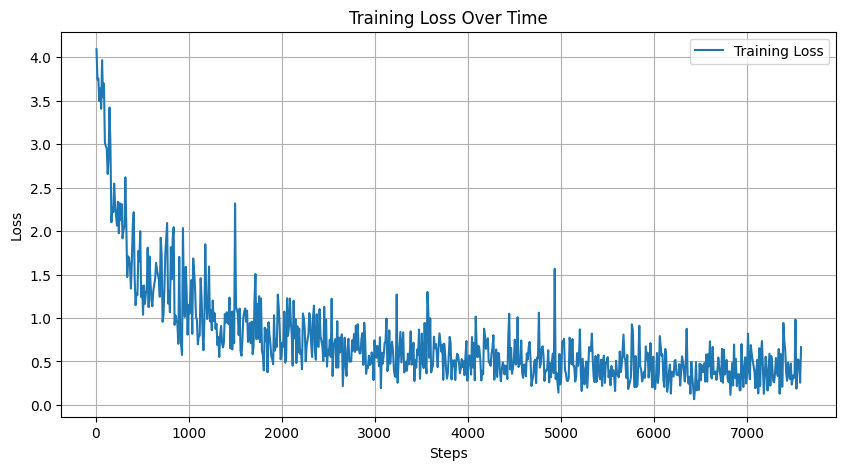

In [203]:


from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# Load the TensorBoard logs
ea = event_accumulator.EventAccumulator('/content/drive/MyDrive/SCAN-CAR/train_log')
ea.Reload()

# Assuming scalar data is logged under the tag 'Loss/train'
if 'Loss/train' in ea.scalars.Keys():
    loss_values = ea.scalars.Items('Loss/train')
    steps = [x.step for x in loss_values]
    values = [x.value for x in loss_values]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, values, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No 'Loss/train' data found in logs.")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24284 samples in 0.001s...
[t-SNE] Computed neighbors for 24284 samples in 2.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24284
[t-SNE] Computed conditional probabilities for sample 2000 / 24284
[t-SNE] Computed conditional probabilities for sample 3000 / 24284
[t-SNE] Computed conditional probabilities for sample 4000 / 24284
[t-SNE] Computed conditional probabilities for sample 5000 / 24284
[t-SNE] Computed conditional probabilities for sample 6000 / 24284
[t-SNE] Computed conditional probabilities for sample 7000 / 24284
[t-SNE] Computed conditional probabilities for sample 8000 / 24284
[t-SNE] Computed conditional probabilities for sample 9000 / 24284
[t-SNE] Computed conditional probabilities for sample 10000 / 24284
[t-SNE] Computed conditional probabilities for sample 11000 / 24284
[t-SNE] Computed conditional probabilities for sample 12000 / 24284
[t-SNE] Computed conditional probabilities for sa

<ipython-input-205-2b4f4e72b89d>:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', marker='o', edgecolor='black', alpha=0.6)


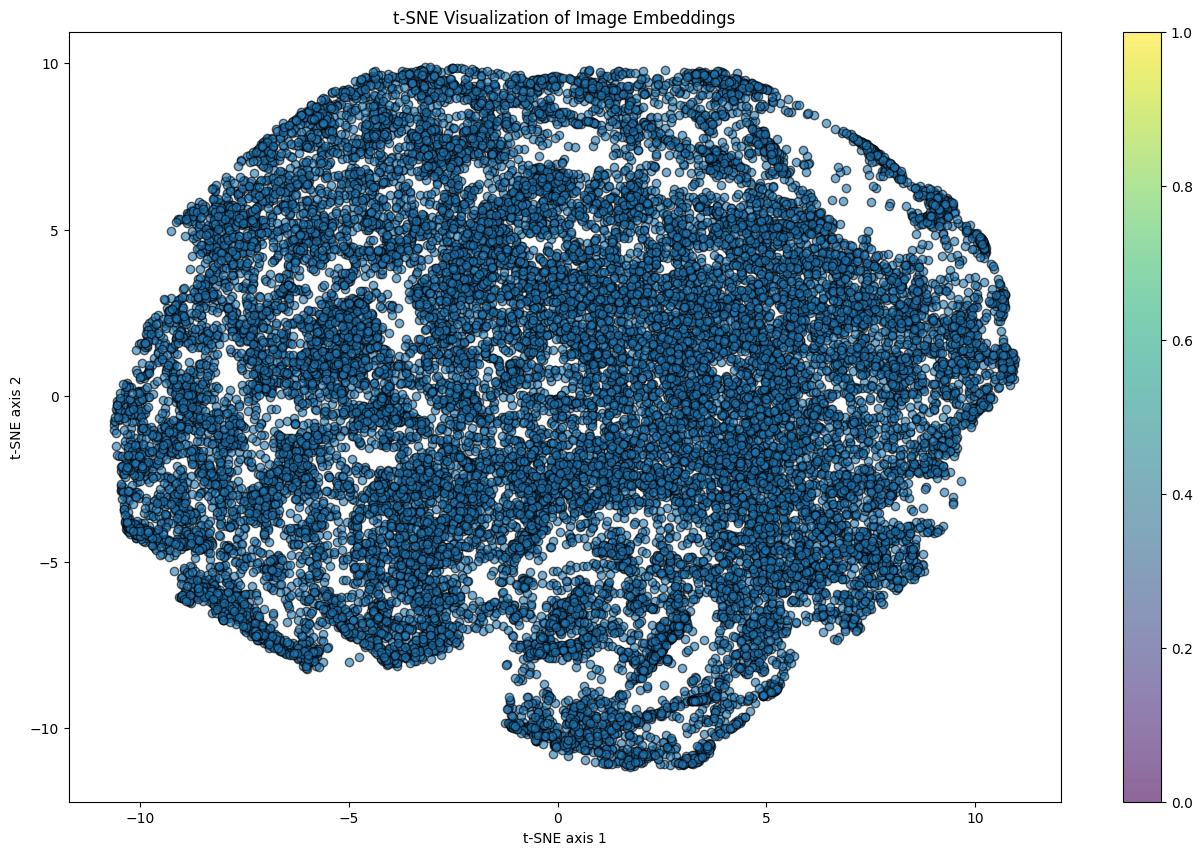

In [205]:
# SimCLR trained, now we do a quick embedding review


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Extract embeddings for a subset of your data
embeddings = []


with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        #images = torch.cat(images, dim=0)
        images = images.to(device)


        embedding = model(images).cpu().numpy()
        embeddings.append(embedding)

# Concatenate all embeddings and
embeddings = np.concatenate(embeddings, axis=0)


# Perform t-SNE embedding
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

# Plot the t-SNE result
plt.figure(figsize=(16, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', marker='o', edgecolor='black', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Image Embeddings')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()